![image.png](https://i.imgur.com/a3uAqnb.png)

In [1]:
from IPython.display import clear_output

In [3]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

# %pip install torch
# %pip install torchvision
# %pip install matplotlib

clear_output()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

# Sign Langauge Problem:

## Intution: The AI is so powrful and important because of its various applications on most if not all the different fields. As a result, we want to help in solving the issue of not understanding sign languages.

## - This notebook contains a detailed implementaiton of a NN uisng Pytorch.

### 1. Data set Details:

- The provided data set is ArASL (Arabic Alphabets Sign Language Dataset). It is as its name says, an arabic sighn langauge for Arabic alphabet. It has a total of 54049 images and their corrssponding labels.

### 2. Size of data:
- Length of train_dataset is 43239,
- Length of val_dataset is 10810

### 3. Labels representations:
- Each sample has a label, which can be one of the 32 classes.
It consist of 32 classes for the alphabet.
- The classes values are integers from 0 up to 31.


### 4. The mapping details:

- Each number represents a charcter. You can see the dictionary in the variable "mapping".

<br/>
-- You can see the mapping in the following:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

### 5. Refrence:
Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [5]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:03<00:00, 18.9MB/s]


In [6]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

## Just run these two cells. You do not need to explore them, but it would be a plus if you understand them.

In [7]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'ghain': 0, 'toot': 1, 'kaaf': 2, 'ta': 3, 'waw': 4, 'taa': 5, 'ya': 6, 'dal': 7, 'thal': 8, 'dha': 9, 'bb': 10, 'haa': 11, 'jeem': 12, 'zay': 13, 'fa': 14, 'ra': 15, 'saad': 16, 'aleff': 17, 'seen': 18, 'nun': 19, 'ha': 20, 'dhad': 21, 'al': 22, 'meem': 23, 'thaa': 24, 'sheen': 25, 'yaa': 26, 'khaa': 27, 'ain': 28, 'la': 29, 'gaaf': 30, 'laam': 31}


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(48, 48)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [9]:
print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
print(len(train_dataset))
print(len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'ghain', 1: 'toot', 2: 'kaaf', 3: 'ta', 4: 'waw', 5: 'taa', 6: 'ya', 7: 'dal', 8: 'thal', 9: 'dha', 10: 'bb', 11: 'haa', 12: 'jeem', 13: 'zay', 14: 'fa', 15: 'ra', 16: 'saad', 17: 'aleff', 18: 'seen', 19: 'nun', 20: 'ha', 21: 'dhad', 22: 'al', 23: 'meem', 24: 'thaa', 25: 'sheen', 26: 'yaa', 27: 'khaa', 28: 'ain', 29: 'la', 30: 'gaaf', 31: 'laam'}
43239
10810


In [10]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image.

The image label: 14 fa


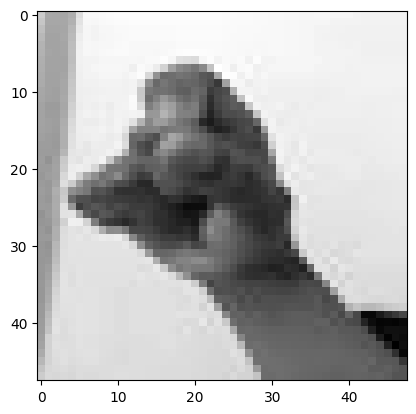

In [11]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

### Create a loop to show 10 different images ranodmly

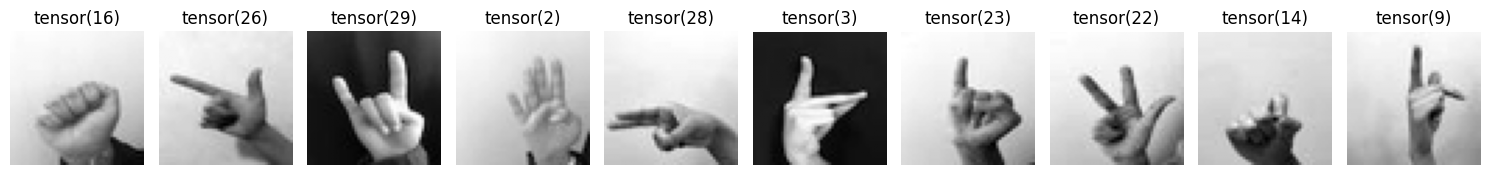

In [12]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 4))
for i in range(10):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    plt.subplot(1, 10, i+1)
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Create a CNN uisng Pytorch. Then, train the model. Play with the layers to get the best model on the validation data, try to reach a 90% accuracy. At least, make 3 different layers. Also, try different activation functions.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Example CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Try 3 layers
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
num_classes = 32
model = SimpleCNN(num_classes).to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (basic version, 5 epochs)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Training Acc: {acc:.2f}%")

# Validate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')


100%|██████████| 676/676 [00:23<00:00, 28.43it/s]


Epoch 1, Loss: 881.535, Training Acc: 61.49%


100%|██████████| 676/676 [00:21<00:00, 31.09it/s]


Epoch 2, Loss: 172.777, Training Acc: 92.87%


100%|██████████| 676/676 [00:22<00:00, 29.83it/s]


Epoch 3, Loss: 100.498, Training Acc: 95.90%


100%|██████████| 676/676 [00:22<00:00, 29.81it/s]


Epoch 4, Loss: 72.106, Training Acc: 96.94%


100%|██████████| 676/676 [00:21<00:00, 31.32it/s]


Epoch 5, Loss: 57.818, Training Acc: 97.51%


100%|██████████| 169/169 [00:04<00:00, 36.55it/s]

Validation Accuracy: 95.47%


# Contributed by: Hassan Alsayhah

![image.png](https://i.imgur.com/a3uAqnb.png)